In [217]:
import clmm

In [218]:
help(clmm.compute_surface_density)

Help on function compute_surface_density in module clmm.theory.func_layer:

compute_surface_density(r_proj, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, halo_profile_model='nfw', massdef='mean', alpha_ein=None, verbose=False, validate_input=True)
    Computes the surface mass density
    
    .. math::
        \Sigma(R) = \int^\infty_{-\infty} dx\; \rho \left(\sqrt{R^2+x^2}\right),
    
    where :math:`\rho(r)` is the 3d density profile.
    
    Parameters
    ----------
    r_proj : array_like
        Projected radial position from the cluster center in :math:`M\!pc`.
    mdelta : float
        Galaxy cluster mass in :math:`M_\odot`.
    cdelta : float
        Galaxy cluster concentration
    z_cl: float
        Redshift of the cluster
    cosmo : clmm.cosmology.Cosmology object
        CLMM Cosmology object
    delta_mdef : int, optional
        Mass overdensity definition; defaults to 200.
    halo_profile_model : str, optional
        Profile model parameterization (letter case i

<font size=5> MODELLING of Quadrupole and Monopole from Adhikari et al. [INCOMPLETE] </font>

Text(0, 0.5, '$\\Sigma$')

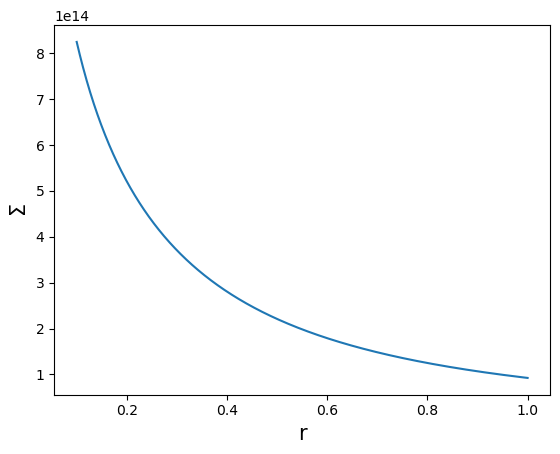

In [219]:
from clmm import Cosmology

cosmo = Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

import numpy as np
import matplotlib.pyplot as plt

r_proj = np.linspace(0.1,1.0,1000)
mdelta=10E14
cdelta=4.0
z_cl=0.3
sigma = clmm.compute_surface_density(r_proj, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model='nfw', massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)

plt.plot(r_proj, sigma)
plt.xlabel('r', fontsize=15)
plt.ylabel('$\Sigma$', fontsize=15)

In [220]:
import scipy
def gamma_tangential_monopole(r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw'):
    kappa_0 = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    
    f = lambda r_i: r_i*clmm.compute_surface_density(r_i, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                         halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                          verbose=False, validate_input=True)
    integrate = np.vectorize(pyfunc = scipy.integrate.quad_vec)
    
    integral, err = integrate(f,0,r)
 
    
    return (2/r**2)*integral - kappa_0
    

In [62]:
%%time

g_t_monopole = gamma_tangential_monopole(r_proj, mdelta, cdelta, z_cl, cosmo, hpmd='nfw')

CPU times: user 2min 5s, sys: 43.8 ms, total: 2min 5s
Wall time: 2min 5s


Text(0, 0.5, '$\\Delta\\Sigma$  (MONOPOLE)')

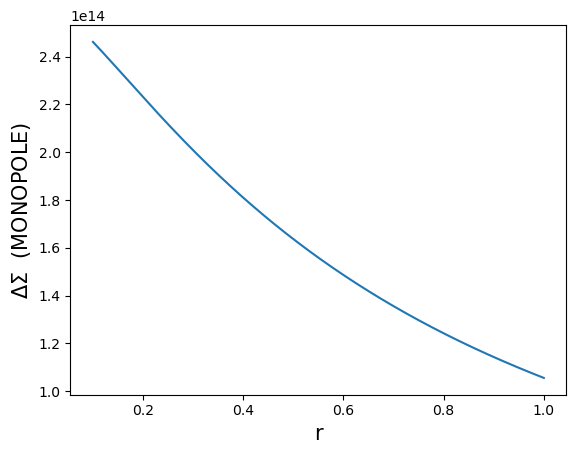

In [66]:
plt.plot(r_proj, g_t_monopole)
plt.xlabel('r', fontsize=15)
plt.ylabel('$\Delta\Sigma$  (MONOPOLE)', fontsize=15)

In [ ]:
def g_tangential_quadrupole(r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw'):
    kappa_0 = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    
    f1 = lambda r_i: (r_i**3)*clmm.compute_surface_density(r_i, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                         halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                          verbose=False, validate_input=True)
    f2 = lambda r_i: (r_i**3)*clmm.compute_surface_density(r_i, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                         halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                          verbose=False, validate_input=True)
    
    integrate = np.vectorize(pyfunc = scipy.integrate.quad_vec)
    
    integral1, err = integrate(f1,0,r)
    integral2, err = integrate(f2,r,np.inf)
 
    
    return (2/r**2)*integral - kappa_0

<font size=5> MODELLING of Quadrupole and Monopole from Shin et al. </font>

Using the expressions for $\Delta\Sigma^{4\theta}$ and $\Delta\Sigma^{Const}$ (estimators for quadrupole) and implementing them using CLMM functionality. 

In [221]:
from scipy.interpolate import InterpolatedUnivariateSpline
def delta_sigma_4theta(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=10000, delta_mdef=200):

    ### DEFINING INTEGRALS:
    r_arr = np.linspace(0.01, np.max(r), sample_N)
    sigma_0_arr = clmm.compute_surface_density(r_arr, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    eta_0_arr = np.gradient(np.log(sigma_0_arr),r_arr)*r_arr
    f = InterpolatedUnivariateSpline(r_arr, (r_arr**3)*sigma_0_arr*eta_0_arr, k=3)  # k=3 order of spline
    integral_vec = np.vectorize(f.integral)
    ###
    
    ### ACTUAL COMPUTATION:
    I_1 = (3/(r**4)) * integral_vec(0, r)
    sigma_0 = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    #eta_0 = np.gradient(np.log(sigma_0),r)
    eta_0_interpolation_func = InterpolatedUnivariateSpline(r_arr, eta_0_arr)
    eta_0 = eta_0_interpolation_func(r) 
    
    return (ell/4.0)*(2*I_1 - sigma_0*eta_0), eta_0_interpolation_func

def delta_sigma_const(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=10000 ,delta_mdef=200):

    ### DEFINING INTEGRALS:
    r_arr = np.linspace(0.01, np.max(r), sample_N)
    sigma_0_arr = clmm.compute_surface_density(r_arr, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    eta_0_arr = np.gradient(np.log(sigma_0_arr),r_arr)*r_arr
    f = InterpolatedUnivariateSpline(r_arr, sigma_0_arr*eta_0_arr/r_arr, k=3)  # k=3 order of spline
    integral_vec = np.vectorize(f.integral)
    ###
    
    ### ACTUAL COMPUTATION:
    I_2 = integral_vec(r, np.inf)
    sigma_0 = clmm.compute_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
    #eta_0 = np.gradient(np.log(sigma_0), r)*r
    eta_0_interpolation_func = InterpolatedUnivariateSpline(r_arr, eta_0_arr)
    eta_0 = eta_0_interpolation_func(r) 
    
    return (ell/4.0)*(2*I_2 - sigma_0*eta_0), eta_0_interpolation_func

def delta_sigma_excess(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000, delta_mdef=200):
    return clmm.compute_excess_surface_density(r, mdelta, cdelta, z_cl, cosmo, delta_mdef=delta_mdef, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)

1.5440708123206437


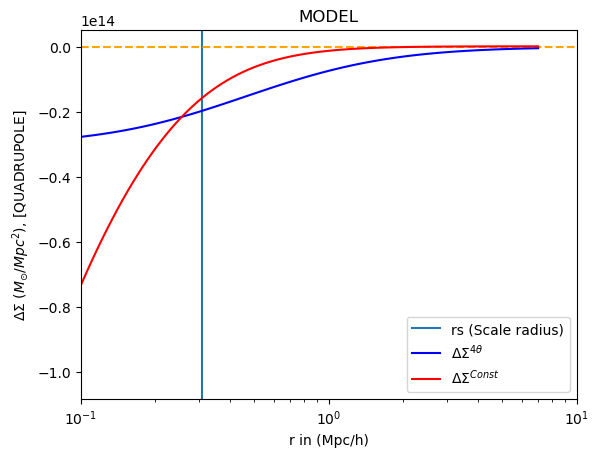

In [232]:
q=2/3
ell = (1-q**2)/(1+q**2)
#ell=0.47
r = np.logspace(-1,1,100)*0.7

mdelta=2.5*1E14
delta_mdef = 200
cdelta=5.0
z_cl=0.3

rdelta = (mdelta/((4*np.pi/3)*cosmo.get_rho_m(z_cl)*delta_mdef))**(1/3)
rs=rdelta/cdelta
print(rdelta)

plt.axvline(rs, label='rs (Scale radius)')
plt.axhline(0, linestyle='--', color='orange')

ds4theta, eta_func = delta_sigma_4theta(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000)
label=r'$\Delta\Sigma^{4\theta}$'
plt.plot(r, ds4theta/0.7, 'b-',label=label)
#plt.plot(r, eta_func(r), 'b.', label=label+str(' eta_0'))



dsconst, eta_func = delta_sigma_const(ell, r, mdelta, cdelta, z_cl, cosmo, hpmd='nfw', sample_N=1000)
label=r'$\Delta\Sigma^{Const}$'
plt.plot(r, dsconst/0.7, 'r-',label=label)
#plt.plot(r, eta_func(r), 'r.', label=label+str(' eta_0'))


plt.xlabel('r in (Mpc/h)')
plt.ylabel(r'$\Delta\Sigma$ ($M_{\odot}/Mpc^{2}$), [QUADRUPOLE]')
plt.xscale('log')
plt.title('MODEL')
plt.xlim([0.1,10.0])
plt.legend()

<font size=10 color='red'> TESTIN' BELOW! BEWARE </font>

In [82]:
from scipy.interpolate import InterpolatedUnivariateSpline

x = np.array([0, 1, 2, 3, 4])

y = np.array([1, 1, 2, 1, -2])
f = InterpolatedUnivariateSpline(x, y, k=1)  # k=1 gives linear interpolation
print(f)
print(f.integral(1.5,2.2), f.integral(1.5,3.3))
f_vec = np.vectorize(f.integral)
print(f_vec(1.5,[2.2,np.inf]))

1.2550000000000003 2.54
[1.255 1.875]


In [59]:
# Testing!
hpmd = 'nfw'
func = np.vectorize(pyfunc = scipy.integrate.quad_vec)
f = lambda r_i: r_i*clmm.compute_surface_density(r_i, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                         halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                          verbose=False, validate_input=True)

func(f,0,[0.001,1.0])

(array([1.73099287e+09, 9.89403849e+13]),
 array([1.24139751e+00, 1.07637988e+05]))

In [68]:
r = np.array([1,2,3])

In [72]:
np.vstack(r)

array([[1],
       [2],
       [3]])

In [98]:
r_arr = np.linspace(0.1,1.0,1000)
mdelta=10E14
cdelta=4.0
z_cl=0.3
cosmo = Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)
sigma_0_arr = clmm.compute_surface_density(r_arr, mdelta, cdelta, z_cl, cosmo, delta_mdef=200, 
                                     halo_profile_model=hpmd, massdef='mean', alpha_ein=None, 
                                     verbose=False, validate_input=True)
eta_0_arr = np.gradient(sigma_0_arr, r_arr)*r_arr
print(sigma_0_arr)

[8.24838294e+14 8.20623362e+14 8.16451594e+14 8.12322233e+14
 8.08234545e+14 8.04187811e+14 8.00181332e+14 7.96214428e+14
 7.92286433e+14 7.88396701e+14 7.84544599e+14 7.80729510e+14
 7.76950833e+14 7.73207981e+14 7.69500380e+14 7.65827470e+14
 7.62188706e+14 7.58583552e+14 7.55011488e+14 7.51472003e+14
 7.47964599e+14 7.44488790e+14 7.41044099e+14 7.37630060e+14
 7.34246219e+14 7.30892129e+14 7.27567356e+14 7.24271472e+14
 7.21004061e+14 7.17764713e+14 7.14553030e+14 7.11368619e+14
 7.08211097e+14 7.05080089e+14 7.01975227e+14 6.98896151e+14
 6.95842507e+14 6.92813949e+14 6.89810140e+14 6.86830745e+14
 6.83875439e+14 6.80943904e+14 6.78035824e+14 6.75150894e+14
 6.72288811e+14 6.69449281e+14 6.66632012e+14 6.63836720e+14
 6.61063127e+14 6.58310957e+14 6.55579941e+14 6.52869816e+14
 6.50180322e+14 6.47511204e+14 6.44862212e+14 6.42233101e+14
 6.39623628e+14 6.37033558e+14 6.34462657e+14 6.31910696e+14
 6.29377450e+14 6.26862698e+14 6.24366224e+14 6.21887813e+14
 6.19427256e+14 6.169843